In [1]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2
import tensorflow.contrib.eager as tfe
from tqdm import tqdm_notebook as tqdm
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.metrics import r2_score

from models import DeepConditionalModel, InvariantNetwork
from inn_utils import train_loop_dataset
from losses import heteroscedastic_loss

D:\Anaconda3\envs\TensorFlowGpu\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


In [2]:
np.set_printoptions(suppress=True)

In [3]:
tf.enable_eager_execution()

In [4]:
%load_ext autoreload
%autoreload 2

# Data loader for seqRNA matrices

In [5]:
class RNADataLoader:
    """A class to sequentially load batches of seq RNA matrices."""
    def __init__(self, batch_size=32, data_path='.', normalize=True, 
                 shuffle=True, n_cells=20, n_genes=20, n_sim_chunk=10000):
        
        self.data_path = data_path
        self._batch_size = batch_size
        self._n_cells = n_cells
        self._n_genes = n_genes
        self._n_sim = n_sim_chunk
        self._idx = 0
        self._normalize = normalize
        self._shuffle = shuffle
        self._num_chunks = self._get_num_chunks()
        self._data_files_list = self._get_data_files()
        self._param_files_list = self._get_param_files()
        assert len(self._data_files_list) == len(self._param_files_list), '# Data files in {} must equal # params files'.format(self.path)
        
        self._global_max = 0
        # This takes time
        if self._normalize:
            self._get_global_max()        
        if self._shuffle:
            self._shuffle_chunks()

    
    def _shuffle_chunks(self):
        """Shuffles the order of the chunks."""

        self._data_files_list, self._param_files_list = shuffle(self._data_files_list, self._param_files_list)
    
    def _get_num_chunks(self):
        
        return len(os.listdir(os.path.join(self.data_path, 'data'))) 
    
    def _get_data_files(self):
        
        return [os.path.join(self.data_path, 'data', f) 
                for f in os.listdir(os.path.join(self.data_path, 'data'))]
    
    def _get_param_files(self):
        
        return [os.path.join(self.data_path, 'params', f) 
                for f in os.listdir(os.path.join(self.data_path, 'params'))]
    
    def _get_global_max(self):
        """Determines the global maximum count over all counts dataset."""
        
        self._global_max = 0
        for data_file in self._data_files_list:
            X = np.load(data_file).astype(np.float32)
            max_count = np.max(X)
            if max_count > self._global_max:
                self._global_max = max_count
        print('Global max determined: ', self._global_max)
            
    
    def load_test(self, n_test, path='.', to_tensor=True):
        """Loads a test dataset."""
        
        X = np.load(os.path.join(path, 'test', 'rna_data_test.npy')).astype(np.float32)
        y = np.load(os.path.join(path, 'test', 'rna_params_test.npy')).astype(np.float32)
        X = X.reshape(self._n_genes, self._n_cells, n_test).T
        if to_tensor:
            X, y = tf.convert_to_tensor(X), tf.convert_to_tensor(y)
        return X, y
    
    def _load_next(self):
        """Loads the current data files."""
        
        # Make sure a corresponding pair of data-params is loaded
        data_file = self._data_files_list[self._idx]
        params_file = self._param_files_list[self._idx]
        assert data_file.split('_')[-1] == params_file.split('_')[-1]
        
        # Load as numpy
        X = np.load(data_file).astype(np.float32)
        y = np.load(params_file).astype(np.float32)
        
        # Convert to N_sim x Genes x Cells tensor
        X = X.reshape(self._n_genes, self._n_cells, self._n_sim).T
        
        # Normalize
        if self._normalize:
            X /= self._global_max
        
        # Create a tf dataset
        dataset = tf.data.Dataset.from_tensor_slices((X, y)).shuffle(X.shape[0]).batch(self._batch_size)

        # Increment index and return dataset
        self._idx = self._idx + 1
        return dataset
    
    def __iter__(self): 
        return self
    
    def __next__(self):
        # Increment index and check if we are at the end of the file list 
        if self._idx == self._num_chunks:
            self._idx = 0
            if self._shuffle:
                self._shuffle_chunks()
            raise StopIteration
        return self._load_next()

In [185]:
class InferenceModel(tf.keras.Model):
    
    def __init__(self, summary_dim, n_params, n_equiv=3):
        super(InferenceModel, self).__init__()
        
        self.bn = tf.keras.layers.BatchNormalization()
        self.inv = InvariantNetwork(summary_dim, n_equiv)
        self.dense = tf.keras.layers.Dense(summary_dim, kernel_initializer='glorot_uniform', activation='elu')
        self.mean_part = tf.keras.layers.Dense(n_params, kernel_initializer='glorot_uniform')
        self.var_part = tf.keras.layers.Dense(n_params, activation='softplus', kernel_initializer='glorot_uniform')
        
    def call(self, x, training=True):
        """Input is a matrix."""
        
        x = self.bn(x, training=training)
        x = self.inv(x)
        x = self.dense(x)
        mean, var = self.mean_part(x), self.var_part(x)
        return mean, var
        

class SelfAttentionHead(tf.keras.Model):
    def __init__(self, key_dim=32, dense_dim=128):
        super(SelfAttentionHead, self).__init__()
        
        self.Wq = tf.keras.layers.Dense(key_dim, use_bias=False, kernel_initializer='glorot_uniform')
        self.Wk = tf.keras.layers.Dense(key_dim, use_bias=False, kernel_initializer='glorot_uniform')
        self.Wv = tf.keras.layers.Dense(key_dim, use_bias=False, kernel_initializer='glorot_uniform')
        
        self.dense_part = tf.keras.models.Sequential([
            tf.keras.layers.Dense(dense_dim, activation='elu', kernel_initializer='glorot_uniform'),
            tf.keras.layers.Dense(dense_dim, activation='elu', kernel_initializer='glorot_uniform'),
            tf.keras.layers.Dense(dense_dim, activation='elu', kernel_initializer='glorot_uniform'),
        ])
        
        
        self.scale = np.sqrt(key_dim)
              
    def call(self, x):
        
        # Obtain queries, keys, and values
        queries = self.Wq(x)
        keys = self.Wk(x)
        values = self.Wv(x)
        
        # Compute self-attention
        qk_t = tf.einsum('bij,bkj->bik', queries, keys)
        weights = tf.nn.softmax(qk_t / self.scale, axis=-1)
        z = tf.einsum('bik,bkj->bij', weights, values)
        
        # Pass through dense
        o = self.dense_part(z)
        return o
  

class AttentionNetwork(tf.keras.Model):
    
    def __init__(self, n_heads=8, key_dim=32, dense_dim=128):
        super(AttentionNetwork, self).__init__()
        
        self.bn = tf.keras.layers.BatchNormalization()
        self.Wo = tf.keras.layers.Dense(key_dim, use_bias=False, kernel_initializer='glorot_uniform')
        self.attention_heads = [SelfAttentionHead(key_dim) for _ in range(n_heads)]
        
        self.dense_part = tf.keras.models.Sequential([
            tf.keras.layers.Dense(dense_dim, activation='elu', kernel_initializer='glorot_uniform'),
            tf.keras.layers.Dense(dense_dim, activation='elu', kernel_initializer='glorot_uniform'),
            tf.keras.layers.Dense(dense_dim, activation='elu', kernel_initializer='glorot_uniform'),
        ])
        
        self.mean_part = tf.keras.layers.Dense(theta_dim, kernel_initializer='glorot_uniform')
        self.var_part = tf.keras.layers.Dense(theta_dim, activation='softplus', kernel_initializer='glorot_uniform')
        
    def call(self, x, training=True):
        
        # Input batch norm
        x = self.bn(x, training=training)
        
        # Calculate attention
        x = tf.concat([head(x) for head in self.attention_heads], axis=-1)
        x = self.Wo(x)
        
        # Pooling
        x = tf.reduce_sum(x, axis=1)
        
        # Non-lineariy after pooling
        o = self.dense_part(x)
        mean, var = self.mean_part(o), self.var_part(o)
        return mean, var
    
    
class GraphNetwork(tf.keras.Model):
    """
    Implements a simple graph network as in Xu et al. (2019).
    """
    
    def __init__(self, k=5, n_dense=3, dense_dim=64):
        super(GraphNetwork, self).__init__()
        
        self.mlp1_list = [
            tf.keras.Sequential([
                tf.keras.layers.Dense(dense_dim, 
                                      activation='elu', 
                                      kernel_initializer='glorot_uniform')
                for _ in range(dense_dim)]
            )
            for _ in range(k)
        ]
 

        self.mlp2 = tf.keras.models.Sequential([
            tf.keras.layers.Dense(dense_dim, activation='elu', kernel_initializer='glorot_uniform'),
            tf.keras.layers.Dense(dense_dim, activation='elu', kernel_initializer='glorot_uniform'),
            tf.keras.layers.Dense(dense_dim, activation='elu', kernel_initializer='glorot_uniform'),
        ])
        
    def call(self, x):
        
        # Compute pairwise interactions 
        outputs_k = x
        for k, mlp in enumerate(self.mlp1_list):
            
            outputs_k = self.pairwise_concat(outputs_k)
            outputs_k = mlp(outputs_k)
            outputs_k = tf.reduce_sum(outputs_k, axis=2)
            
        # Compute final output
        o = tf.reduce_sum(outputs_k, axis=1)
        o = self.mlp2(o)
        return o
        
        
    def pairwise_concat(self, x):
        """
        Transforms 3D to 4D (pairwise concatenated).
        """
        
        b = x.shape[0]
        n = x.shape[1]
        d = x.shape[2]
        
        x_tiled = tf.reshape(tf.tile(x, [1, n, 1]), (b, n, n, d))
        x_tiled_t = tf.transpose(x_tiled, [0, 2, 1, 3])
        x = tf.concat((x_tiled_t, x_tiled), axis=-1)
        return x 

In [186]:
test = GraphNetwork(k=5)

In [187]:
b = tf.random_normal((32, 50, 10))

In [189]:
test(b)

<tf.Tensor: id=30658558, shape=(32, 64), dtype=float32, numpy=
array([[-1.        , 33.632744  , -0.99998266, ..., 21.132557  ,
        -0.99999785, -1.        ],
       [-1.        , 36.206833  , -0.99999106, ..., 23.677732  ,
        -1.        , -1.        ],
       [-1.        , 31.997187  , -0.99992466, ..., 22.280756  ,
        -0.9999963 , -1.        ],
       ...,
       [-1.        , 31.60629   , -0.99987936, ..., 22.79675   ,
        -0.9999966 , -1.        ],
       [-1.        , 30.949318  , -0.99980825, ..., 22.948011  ,
        -0.99999374, -1.        ],
       [-1.        , 28.03872   , -0.99784636, ..., 24.034792  ,
        -0.9999762 , -1.        ]], dtype=float32)>

In [7]:
def remove_implausible(X_batch, theta_batch, zeros_tolerated=360):
    """Removes implausible simulated matrices from batch."""
    
    plausible = tf.reduce_sum(tf.cast(tf.equal(X_batch, 0.), tf.int32), axis=(1, 2)) < zeros_tolerated
    X_batch_plausible = tf.boolean_mask(X_batch, plausible, axis=0)
    theta_batch_plausible = tf.boolean_mask(theta_batch, plausible, axis=0)
    return X_batch_plausible, theta_batch_plausible

In [8]:
def plot_true_est_scatter(model, y_pred, y_test, params_names, figsize=(20, 4), filename=None):
    """Plots a scatter plot with abline of the estimated posterior means vs true values."""
    
    y_pred = y_pred.numpy()
    y_test = y_test.numpy()
    
    # Initialize figure

    # Determine figure layout
    if len(param_names) >= 6:
        n_col = int(np.ceil(len(param_names) / 2))
        n_row = 2
    else:
        n_col = int(len(param_names))
        n_row = 1

    # Initialize figure
    f, axarr = plt.subplots(n_row, n_col, figsize=figsize)
    if n_row > 1:
        axarr = axarr.flat

    # --- Plot true vs estimated posterior means on a single row --- #
    for j in range(len(params_names)):
        
        # Plot true vs estimated
        axarr[j].scatter(y_test[:, j], y_pred[:, j], color='black', alpha=0.4)
        
        # Plot AB line
        axarr[j].plot(axarr[j].get_xlim(), axarr[j].get_xlim(), '--', color='black')
        
        # Compute NRMSD
        rmse = np.sqrt(np.mean( (y_pred[:, j] - y_test[:, j])**2 ))
        nrmse = rmse / (y_pred[:, j].max() - y_test[:, j].min())
        axarr[j].text(0.1, 0.9, 'NRMSE={:.3f}'.format(nrmse),
                     horizontalalignment='left',
                     verticalalignment='center',
                     transform=axarr[j].transAxes,
                     size=10)
        
        # Compute R2
        r2 = r2_score(y_pred[:, j], y_test[:, j])
        axarr[j].text(0.1, 0.8, '$R^2$={:.3f}'.format(r2),
                     horizontalalignment='left',
                     verticalalignment='center',
                     transform=axarr[j].transAxes,
                     size=10)
        
        if j == 0:
            # Label plot
            axarr[j].set_xlabel('True')
            axarr[j].set_ylabel('Estimated')
        axarr[j].set_title(params_names[j])
        axarr[j].spines['right'].set_visible(False)
        axarr[j].spines['top'].set_visible(False)
    
    # Adjust spaces
    f.tight_layout()
    
    if filename is not None:
        f.savefig('figures/Splatter_scatter.png', dpi=600)
    
    plt.show()

# Initialization 

In [9]:
# --- Training hyperparameters --- #
param_names = [r'$\alpha$', r'$\beta$', r'$\mu^{O}$', r'$\pi^{O}$', 
               r'$\sigma^{O}$', r'$\mu^{L}$', r'$\sigma^{L}$', r'$\phi$']

theta_dim = 8
summary_dim = 128
global_step = tfe.Variable(0, dtype=tf.int32)
batch_size = 64
epochs = 100
n_inv_blocks = 10
data_path = 'D:\\seqRNA2'
starter_learning_rate = 0.001
decay_steps = 9375
decay_rate = .95
clip_value = 5.
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, decay_steps, decay_rate)

In [10]:
# --- Data loader --- #
n_chunks = 50
n_sim_chunk = 10000
n_cells = 20
n_genes = 20
data_loader  = RNADataLoader(batch_size, data_path, normalize=False, 
                             n_sim_chunk=n_sim_chunk, n_cells=n_cells, n_genes=n_genes)

## Create a test set

In [11]:
X_test, theta_test = data_loader.load_test(n_test=500, path=data_path)

## Create networks

In [12]:
model = AttentionNetwork(dense_dim=summary_dim)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

## Checkpoint manager

In [13]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/seqrna', max_to_keep=2)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Restored from ./checkpoints/seqrna\ckpt-213


## Plot performance of untrained model

Instructions for updating:
Colocations handled automatically by placer.


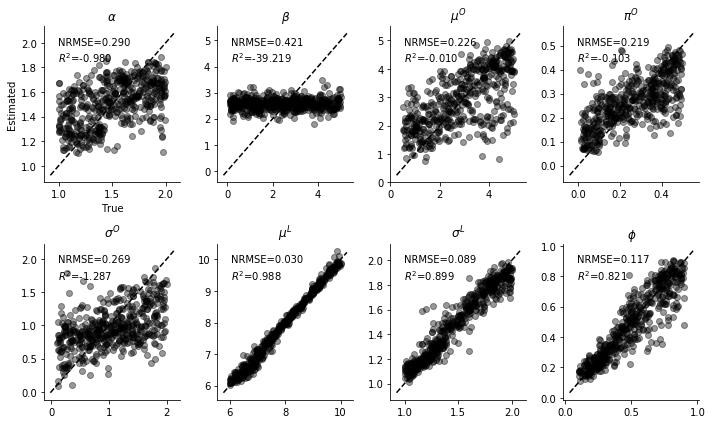

In [14]:
theta_pred = model(X_test)[0]
plot_true_est_scatter(model, theta_pred, theta_test, 
                      param_names, figsize=(10, 6), filename=None)

# Train the model

In [16]:
def run_epoch(model, optimizer, data_loader, X_test, y_test, 
              p_bar, global_step=None, clip_value=5.):
    """Runs a single epoch."""
    
    for chunk in data_loader:
        for X_batch, y_batch in chunk:
        
            with tf.GradientTape() as tape:

                # Forward pass
                y_mean, y_var = model(X_batch)

                # Compute total loss
                loss = heteroscedastic_loss(y_batch, y_mean, y_var)
             
            # One step backprop
            gradients = tape.gradient(loss, model.trainable_variables)
            
            # Validations score
            y_mean_val, y_var_val = model(X_test, training=False)
            train_rec = tf.sqrt(tf.reduce_mean(tf.reduce_sum(tf.square(y_batch - y_mean), axis=-1), axis=-1))  
            val_rec = tf.sqrt(tf.reduce_mean(tf.reduce_sum(tf.square(y_test - y_mean_val), axis=-1), axis=-1))
            val_loss = heteroscedastic_loss(y_test, y_mean_val, y_var_val)
            
            
            if clip_value is not None:
                gradients, _ = tf.clip_by_global_norm(gradients, clip_value)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables), global_step=global_step)

            # Update p-bar
            p_bar.set_postfix_str("Loss:{0:.3f},Val.Loss:{1:.3f},Rec.:{2:.3f},Val.Rec.:{3:.3f}".format(
            loss.numpy(), val_loss.numpy(), train_rec.numpy() , val_rec.numpy()))
            p_bar.update(1)
        # Save after each chunk
        manager.save()

Instructions for updating:
Use standard file APIs to delete files with this prefix.


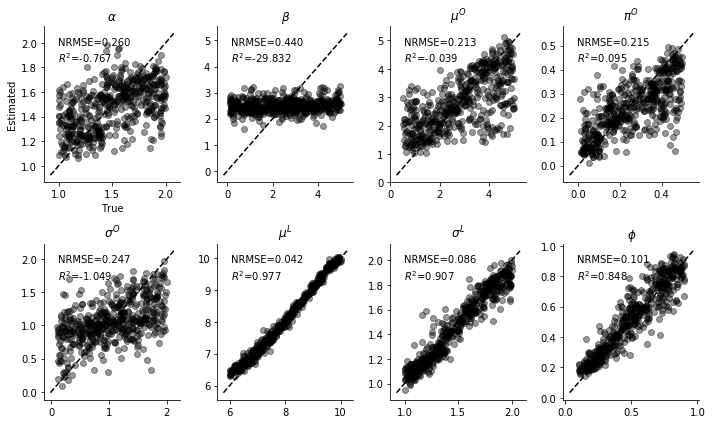

KeyboardInterrupt: 

In [17]:
for ep in range(1, epochs+1):
    with tqdm(total = (n_sim_chunk * n_chunks) // batch_size, desc='Epoch {}'.format(ep)) as p_bar:
        
        # Run epoch
        run_epoch(model, optimizer, data_loader, X_test, theta_test, p_bar, clip_value=clip_value)
        
        # Predict test
        theta_pred_test = model(X_test, training=False)[0]
        plot_true_est_scatter(model, theta_pred_test, theta_test, 
                              param_names, figsize=(10, 6), filename=None)

In [ ]:
X = np.load("D:/seqRNA/data/rna_data_5.npy").astype(np.float32)
y = np.load("D:/seqRNA/params/rna_params_5.npy").astype(np.float32)
X = X.reshape(n_genes, n_cells, n_sim).T
x1D, y1D = view1D(y, y)
Xout = (x1D[:,None] == y1D).astype(float)
np.sum(Xout)dd

In [ ]:
# Predict test
theta_pred_test = model(X_test, training=False)[0]
plot_true_est_scatter(model, theta_pred_test, theta_test, 
                      param_names, figsize=(10, 6), filename='seq')

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(15, 15))

# Generate a mask for the upper triangle
mask = np.zeros_like(c, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(c, cmap=cmap, mask=mask, vmax=np.max(c), vmin=-np.max(c), center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True, ax=ax)

In [ ]:
sns.pairplot(pd.DataFrame(theta_hat, columns=param_names))